In [1]:
from sklearn.svm import SVC
import pandas as pd
from sklearn import datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import numpy as np

### Метод опорных векторов

Для решения задачи методом опорных векторов воспользуемся одним из датасетов, доступных в scikit-learn — 20newsgroups.

In [2]:
newsgroups = datasets.fetch_20newsgroups(
                    subset='all', 
                    categories=['alt.atheism', 'sci.space']
             )

Для того чтобы найти числовое представление текстовых данных вычислим TF-IDF. Используем класс 
`sklearn.feature_extraction.text.TfidfVectorizer`

In [3]:
y = newsgroups.target
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(newsgroups.data)

Подбор параметров удобно делать с помощью класса sklearn.grid_search.GridSearchCV:

In [4]:
grid = {'C': np.power(10.0, np.arange(-5, 6))}
cv = KFold(n_splits=5, shuffle=True, random_state=241)
clf = SVC(kernel='linear', random_state=241)
gs = GridSearchCV(clf, grid, scoring='accuracy', cv=cv)
gs.fit(X_vect, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=241, shuffle=True),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='linear',
                           max_iter=-1, probability=False, random_state=241,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

Найдем минимальный лучший параметр C:

In [8]:
best_c = gs.best_params_
print(best_c)

{'C': 1.0}


Обучим SVM по всей выборке с оптимальным параметром C, найденным на предыдущем шаге:

In [12]:
clf_c = SVC(C = best_c['C'], kernel='linear', random_state=241)

clf_c.fit(X_vect, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=241,
    shrinking=True, tol=0.001, verbose=False)

In [31]:
clf_c.coef_

<1x28382 sparse matrix of type '<class 'numpy.float64'>'
	with 18404 stored elements in Compressed Sparse Row format>

Найдем 10 слов с наибольшим абсолютным значением веса:

In [32]:
most_important_words_indexes = np.argsort(abs(clf_c.coef_.toarray()[0]))[-10:]

most_important_words = np.array(vectorizer.get_feature_names())[most_important_words_indexes]

most_important_words_sorted = sorted(most_important_words)

In [36]:
print(most_important_words_sorted)

['atheism', 'atheists', 'bible', 'god', 'keith', 'moon', 'religion', 'sci', 'sky', 'space']


### Логистическая регрессия

In [55]:
import os

os.chdir('C:/Users/user/Downloads/')

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

Воспользуемся данными Real estate price prediction (прогноз цен на недвижимость в зависимости от возраста дома, расстояния до метро, ближайших магазинов и т.п.) https://www.kaggle.com/quantbruce/real-estate-price-prediction

In [46]:
real_estate = pd.read_csv('real estate.csv')
real_estate = real_estate.drop(columns=['No'])

In [57]:
real_estate.head(10)

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
5,2012.667,7.1,2175.03000,3,24.96305,121.51254,32.1
6,2012.667,34.5,623.47310,7,24.97933,121.53642,40.3
7,2013.417,20.3,287.60250,6,24.98042,121.54228,46.7
8,2013.500,31.7,5512.03800,1,24.95095,121.48458,18.8
9,2013.417,17.9,1783.18000,3,24.96731,121.51486,22.1


In [50]:
X = real_estate.iloc[:, 0:6]
y = real_estate['Y house price of unit area'].copy()

Сформирмируем обучающую и тестовую выборки и обучим выборку методом логистической регрессии:

In [58]:
y[y < 40] = -1
y[y > 40] = 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LogisticRegression()

model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Выполним предсказание для тестовой выборки:

In [ ]:
y_pred = model.predict(X_test)

Выполним оценку AUC-ROC для построенной модели:

In [52]:
accuracy_score(y_test, y_pred)

0.8313253012048193

Построим ROC-кривую:

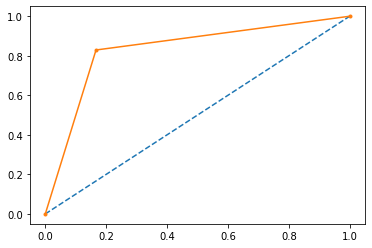

In [56]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()